# Introduction to Machine Learning (CSCI-UA.473)

### Homework 3
#### Due: November 12th, 2023 at 11:59PM


#### Name: Gil Halevi
#### Email: gh2354@nyu.edu

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, RandomSampler

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set up a transform to convert the images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

num_train = len(trainset)
num_val = int(0.1 * num_train)
num_train -= num_val

train_dataset, val_dataset = random_split(trainset, [num_train, num_val])

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48814045.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Question 1: Data Visualization (15 points)

**Task 1.1 (3 points):** Perform the following visualizations in a single plot with 5 subplots:
- Display five random images along with their corresponding labels.
- Create a bar plot to visualize the distribution of classes in the CIFAR-10 dataset.

In [3]:
classes = [lbl for img, lbl in trainset]

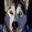

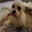

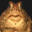

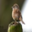

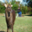

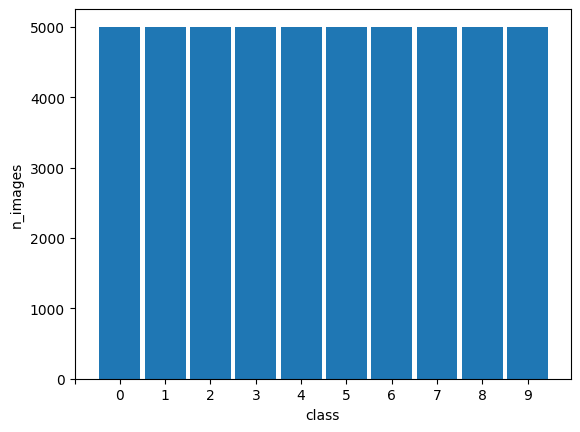

In [4]:
images = []
indices = torch.randint(0, len(trainset),(5,))
toimg = transforms.ToPILImage()
for i in range(5):
  image = trainset[indices[i]][0]
  im = toimg(image)
  display(im)
fig, ax = plt.subplots()
ax.hist(x=classes, label=[str(x) for x in range(11)], rwidth=0.9, align='right', bins=range(11))
ax.set_xticks(range(11))
ax.set_xticklabels(['']+[str(x) for x in range(10)])
ax.set_xlabel("class")
ax.set_ylabel("n_images")
fig.show()

**Task 1.2 (5 points):**  Perform the following data augmentation on the images of the training dataset:
*   RandomCrop with a 32-pixel crop size and 4 pixel padding
*   RandomHorizontalFlip
*   Any other augmentation of your choice

Choose a couple of random images from the training set and display the original image and the augmented images next to each other. Which augmentation did you try?  

**Task 1.3 (3 points):** Standardization of images is a preprocessing step used to normalize the pixel values of the images. To standardize an image, we subtract the mean value from each pixel, and then divide the result by the standard deviation.

Standardize the image by applying mean values $(0.4914, 0.4822, 0.4465)$ and standard deviation values $(0.2023, 0.1994, 0.2010)$.

Hint: Look into torchvision.transforms.Normalize()


I tried the augmentation colorjitter

format:
 base
 randomcropped
 randomhorizontalflip 
 colorjitter 
 standardized


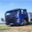

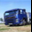

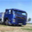

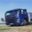

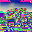

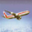

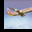

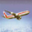

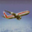

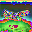

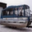

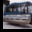

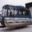

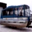

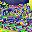

In [5]:
## Add code here
images = []
indices = torch.randint(0, len(trainset),(5,))
randomcrop = transforms.RandomCrop(size=32, padding=4)
randomhorflip = transforms.RandomHorizontalFlip()
colorjitter = transforms.ColorJitter(brightness=0.3, contrast = 0.3, saturation = 0.3)
standardize = transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
toimg = transforms.ToPILImage()
print("format:\n base\n randomcropped\n randomhorizontalflip \n colorjitter \n standardized")
for i in range(3):
  image = trainset[indices[i]][0]
  image_randomcrop = randomcrop(image)
  image_randomhorflip = randomhorflip(image)
  image_colorjitter = colorjitter(image)
  image_standardized = standardize(image)
  display(toimg(image))
  display(toimg(image_randomcrop))
  display(toimg(image_randomhorflip))
  display(toimg(image_colorjitter))
  display(toimg(image_standardized))


**Task 1.4 (4 points):** Create the train, validation and test data loaders with a batch size of 64 and four workers. Explain the roles of the shuffle parameter and the number of workers parameter.

In [6]:
## Add code here
train_loader = DataLoader(train_dataset, batch_size = 64, num_workers=4)
validation_loader = DataLoader(val_dataset)
test_loader = DataLoader(testset)

# the shuffle parameter determines whether or not the data is shuffled before use
# if False, the data is fed in the exact way it is arranged in the datset
# if True, the data is shuffled (ie, randomized) before feeding in

# the number of worker parameters determines how many cores are used in parallel to load the data
# so if 4, there will be 4 workers threads on 4 different cores loading data

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Question 2: MLP architecture (10 points)

**Task 2.1 (5 points):** Complete the following architecture for MLP to train the CIFAR-10 dataset.

In [7]:
print(trainset[1][0].shape)

torch.Size([3, 32, 32])


In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 128)                             # output size is 128
        self.fc2 = nn.Linear(128,64)                             # Hidden layer with 64 units
        self.fc3 = nn.Linear(64, 10)                             # Output layer with 10 units (classes)
        self.full = nn.Sequential(self.fc1,nn.ReLU(), self.fc2,nn.ReLU(), self.fc3, nn.Softmax())
    def forward(self, x):
        # Flattened input -> FC1 -> ReLU -> FC2 -> ReLU -> Output
        x = x.reshape(-1,32*32*3)
        return self.full(x)

# Create an instance of the model
model = MLP()

**Task 2.2 (3 points):** Specify the training configuration as follows:
- Use the SGD optimizer with weight_decay=1e-4. What does this parameter mean?
- Use 64 batch size.


Weight decay adds a loss of the sum of squares of all the weights multiplied by weight_decay to the total loss

In [9]:
## Add code here
optim = torch.optim.SGD(model.parameters(),weight_decay = 1e-4, lr = 1e-3)
# batch size already specified above

**Task 2.3 (2 points)** Train the MLP for 10 epochs in the code-cell below, where an epoch is defined as one full pass over the training set.

In [11]:
## Add code here
loss_fn = nn.CrossEntropyLoss()
for epoch in range(10):
  for inpt,target in train_loader:
    outs = model(inpt)
    loss = loss_fn(outs, target)
    loss.backward()
    optim.step()
    optim.zero_grad()
  print(f'Epoch: {epoch} \tLoss: {loss}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0 	Loss: 2.302412271499634
Epoch: 1 	Loss: 2.3014657497406006
Epoch: 2 	Loss: 2.3004443645477295
Epoch: 3 	Loss: 2.2995645999908447
Epoch: 4 	Loss: 2.2988667488098145
Epoch: 5 	Loss: 2.2983174324035645
Epoch: 6 	Loss: 2.2977654933929443
Epoch: 7 	Loss: 2.2971363067626953
Epoch: 8 	Loss: 2.2964980602264404
Epoch: 9 	Loss: 2.295849323272705


### Question 3: Convolution network (38 points)


**Task 3.1 (10 points):** You are tasked with creating a neural network architecture that includes a novel structural unit. This unit is designed to facilitate the training of very deep networks by enabling the flow of information through shortcuts. The architecture of this unit can be described as follows:

1. **Main Path:**
   - The main path should consist of two convolutional layers, each followed by a batch normalization layer and a ReLU activation function.
   - You can choose the filter sizes and the number of filters for each convolutional layer.

2. **Shortcut Path:**
   - The shortcut path should provide a direct, unaltered connection from the input to the output of this unit.
   - No additional weights or transformations are applied to this path; it is a simple identity mapping.

3. **Combining Paths:**
   - The key concept of this unit is adding the output of the shortcut path to the output of the main path.
   - This addition operation should be performed element-wise, meaning that the feature maps from both paths are element-wise summed.

You need to implement this architectural unit below.

In [ ]:
# Define a custom architectural block class that inherits from nn.Module
class ArchitecturalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ArchitecturalBlock, self).__init__()

        # Define the first convolutional layer
        self.fc1 = nn.Conv2d(in_channels,16,3, stride=stride, padding=1)

        # Define the second convolutional layer
        self.fc2 = nn.Conv2d(16,out_channels,3,stride=1, padding=1)


        self.adjust_channels = nn.Conv2d(in_channels, out_channels,1)
        # Store parameters for downsampling and stride
        self.down_sample = down_sample
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.down_sample = down_sample


    # Define a method for down-sampling
    def down_sampling(self, x):
        # Implement down-sampling here using the appropriate method or layer
        out = F.pad(x, (0, 0, 0, 0, 0, self.out_channels - self.in_channels))
        out = nn.MaxPool2d(2, stride=self.stride)(out)
        return out


    # Define the forward pass for the block
    def forward(self, x):
        # Save a copy of the input for the residual connection
        shortcut = x

        batch_norm1 = nn.BatchNorm2d(16)
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        x = self.fc1(x)
        x = batch_norm1(x)
        x = F.relu(x)

        batch_norm2 = nn.BatchNorm2d(self.out_channels)
        # Apply the second convolutional layer and batch normalization
        x = self.fc2(x)
        x = batch_norm2(x)
        x = F.relu(x)

        # Implement down-sampling here using the down_sampling method
        shortcut=self.down_sampling(shortcut)

        # Add the shortcut connection to the output and apply ReLU thereafter
        x = shortcut + x
        x = F.relu(x)
        return x


**Task 3.2 (10 points):** Now implement `Model` class. Assume the `block` argument will be `ArchitecturalBlock` we implemented above. Here are required implementation details.

* In `init` method, specifiy all details of convolution, batch norm layers.
* In `get_layers` method, set down_sample boolean variable according to the stride information. Then, define a list of architectural blocks (`layer_list`). Make sure the down-sample only occurs at the first block in demand.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_layers, block, num_classes=10):
        super(Model, self).__init__()


        self.num_layers = num_layers

        # input(channel:3) -> (conv 3x3) -> (bn) -> (relu) -> output(channel:16)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # feature map size = 16x32x32
        self.layers_2n = self.get_layers(block, 16, 32, stride=2)
        # feature map size = 32x16x16
        self.layers_4n = self.get_layers(block, 32, 64, stride=2)
        # feature map size = 64x8x8
        self.layers_6n = self.get_layers(block, 64, 16*6, stride=2)

        # output layers
        self.avg_pool = nn.AvgPool2d(4, stride=1)
        self.fc_out = nn.Linear(16*6, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 1:
            down_sample = False
        else:
            down_sample = True

        layer_list = nn.ModuleList([block(in_channels, out_channels, stride = stride, down_sample = down_sample),nn.ReLU()])

        ##############################
        # Implement here: layer_list #
        ##############################

        return nn.Sequential(*layer_list)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers_2n(x)
        x = self.layers_4n(x)
        x = self.layers_6n(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)

        return x

In [ ]:
def model():
    block = ArchitecturalBlock
    model = Model(3, block)
    return model

**Task 3.3 (5 points):** Use the model training configuration as follows to train the model:
- Use the SGD optimizer with weight_decay=1e-4.
- Use 64 batch size.
- The learning rate starts from 0.1 and is decayed at 32,000 and 48,000 step with 0.1 factor.

In [ ]:
## add code here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

validation_loader = DataLoader(val_dataset)

loss_fn = nn.CrossEntropyLoss()


step = 0
train_losses=[]
val_losses = []
cnn_model = model()
optim = torch.optim.SGD(cnn_model.parameters(),0.1, weight_decay = 1e-4)

early_stopping = False

stop = False
for epoch in range(10):
  train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

  if stop:
    break
  for input, target in train_loader:
    step+= 1
    if step == 32000/64:
      optim = torch.optim.SGD(cnn_model.parameters(),0.1*0.1, weight_decay = 1e-4)
    if step == 48000/64:
      optim = torch.optim.SGD(cnn_model.parameters(),0.1*0.1*0.1, weight_decay = 1e-4)
      early_stopping = True # only turn on early stopping after you're on the third setting
    input, target = input.to(device),target.to(device)
    output = cnn_model(input)
    loss = loss_fn(output, target)
    loss.backward()
    train_losses.append(loss.detach())
    optim.step()
    optim.zero_grad()
    if early_stopping:
      if step % 50 == 0: # calculate val loss every 50 steps, check if you need to early stop each time
        with torch.no_grad():
          val_loss = 0
          for input, target in validation_loader:
            input, target = input.to(device), target.to(device)
            output = cnn_model(input)
            loss = loss_fn(output, target)
            val_loss+=loss
          val_losses.append(val_loss.detach().item())
          if len(val_losses)>1 and val_losses[-1] <= val_losses[-2]:
            stop = True
            break
  print(epoch)

0
1


In [ ]:
print(val_losses)

[12045.4560546875, 12109.1259765625, 12141.13671875, 12153.345703125, 12176.7294921875, 12154.4267578125]


**Task 3.4 (3 points):** Plot train loss and calculate test performance. Save the best model by implementing early stopping during training.

Early stopping is a form of regularization used to avoid overfitting when training a machine learning model. It works by monitoring the model's performance on a validation set and stopping the training process once the model's performance ceases to improve, or even starts to deteriorate, on this out-of-sample data. This ensures that we train the model just until it is optimal and not beyond, which can save computational resources and prevent the model from learning the noise in the training set.


test loss: 24304.712890625


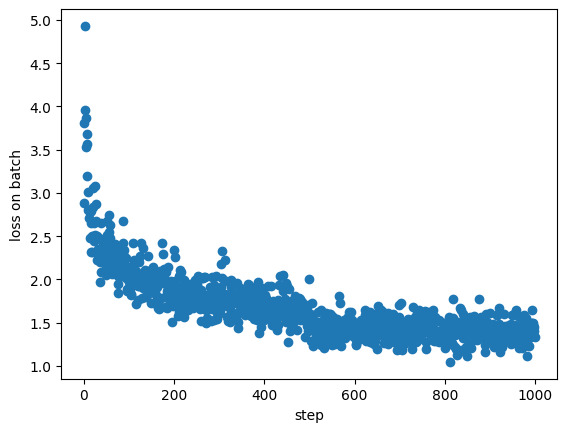

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
## Add code for test performance here
fig, axs = plt.subplots()
axs.scatter(np.arange(0,len(train_losses),1),train_losses)
axs.set_xlabel("step")
axs.set_ylabel("loss on batch")
fig.show()
def test(model):
  test_loader = DataLoader(testset)
  with torch.no_grad():
    test_loss = 0
    for input, target in test_loader:
      input, target = input.to(device), target.to(device)
      output = model(input)
      loss = loss_fn(output, target)
      test_loss+=loss
    return test_loss.detach().item()
test_loss = test(cnn_model)
print("test loss:", test_loss)


**Task 3.5 (5 points):** Create a copy of the Architecture block but without the shortcut connection in this case. Train the model with early stopping and compare it to the above model that uses the shortcut connection and MLP using a bar chart.

In [ ]:
## Add code here
# Define a custom architectural block class that inherits from nn.Module

class ArchitecturalBlockNoShortcut(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ArchitecturalBlock, self).__init__()

        # Define the first convolutional layer
        self.fc1 = nn.Conv2d(in_channels,16,3, stride=stride, padding=1)

        # Define the second convolutional layer
        self.fc2 = nn.Conv2d(16,out_channels,3,stride=1, padding=1)


        self.adjust_channels = nn.Conv2d(in_channels, out_channels,1)
        # Store parameters for downsampling and stride
        self.down_sample = down_sample
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels


    # Define the forward pass for the block
    def forward(self, x):
        batch_norm1 = nn.BatchNorm2d(16)
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        x = self.fc1(x)
        x = batch_norm1(x)
        x = F.relu(x)

        batch_norm2 = nn.BatchNorm2d(self.out_channels)
        # Apply the second convolutional layer and batch normalization
        x = self.fc2(x)
        x = batch_norm2(x)
        x = F.relu(x)
        return x

# ns = no shortcut
def model_ns():
    block = ArchitecturalBlockNoShortcut
    model = Model(3, block)
    return model

## add code here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

validation_loader = DataLoader(val_dataset)
test_loader = DataLoader(testset)

loss_fn = nn.CrossEntropyLoss()


step = 0
train_losses_ns=[]
val_losses_ns = []
cnn_model_ns = model()
optim = torch.optim.SGD(cnn_model_ns.parameters(),0.1, weight_decay = 1e-4)

early_stopping = False

stop = False
for epoch in range(10):
  train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

  if stop:
    break
  for input, target in train_loader:
    step+= 1
    if step == 32000/64:
      optim = torch.optim.SGD(cnn_model_ns.parameters(),0.1*0.1, weight_decay = 1e-4)
    if step == 48000/64:
      optim = torch.optim.SGD(cnn_model_ns.parameters(),0.1*0.1*0.1, weight_decay = 1e-4)
      early_stopping = True # only turn on early stopping after you're on the third setting
    input, target = input.to(device),target.to(device)
    output = cnn_model_ns(input)
    loss = loss_fn(output, target)
    loss.backward()
    train_losses_ns.append(loss.detach())
    optim.step()
    optim.zero_grad()
    if early_stopping:
      if step % 50 == 0: # calculate val loss every 50 steps, check if you need to early stop each time
        with torch.no_grad():
          val_loss = 0
          for input, target in validation_loader:
            input, target = input.to(device), target.to(device)
            output = cnn_model_ns(input)
            loss = loss_fn(output, target)
            val_loss+=loss
          val_losses_ns.append(val_loss.detach().item())
          if len(val_losses_ns)>1 and val_losses[-1] <= val_losses[-2]:
            stop = True
            break
test_loss_ns=test(cnn_model_ns)

[Text(0, 0, 'test loss with shortcut'),
 Text(1, 0, 'test loss without shortcut'),
 Text(2, 0, '')]

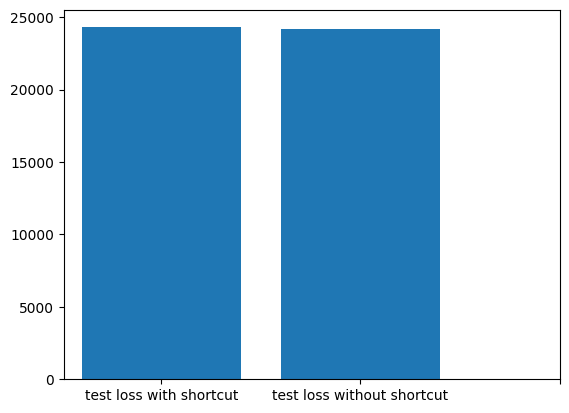

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots()
axs.bar([0,1], [test_loss, test_loss_ns])
axs.set_xticks(range(3))
axs.set_xticklabels(["test loss with shortcut", "test loss without shortcut",""])

**Task 3.6 (5 points):** Extract feature maps from one of the convolutional layers. Visualize these feature maps to understand what the network is learning. Can you see something interesting in them? Elaborate.

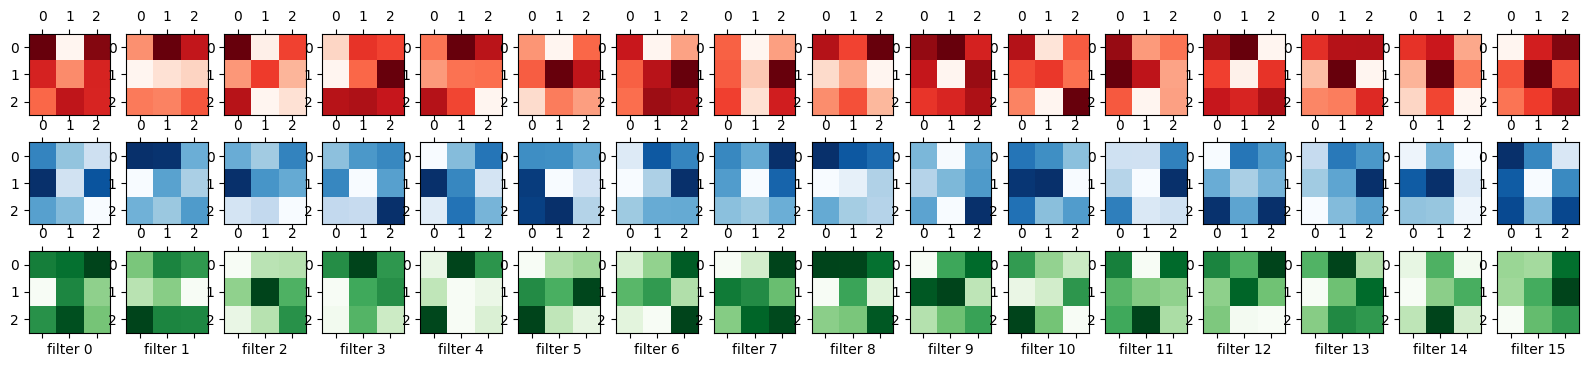

In [ ]:
## Add code here
fig, ax = plt.subplots(3,16, figsize=(20,4))
for i in range(16):
  ax[0][i].matshow(cnn_model.conv1.weight[i][0].detach().numpy(),cmap="Reds")
  ax[1][i].matshow(cnn_model.conv1.weight[i][1].detach().numpy(),cmap="Blues")
  ax[2][i].matshow(cnn_model.conv1.weight[i][2].detach().numpy(),cmap="Greens")
  ax[2][i].set_xlabel("filter "+str(i))
# print(cnn_model.conv1.weight[0][0])


Above are each of the 16 filters from the first layer of the first convolutional layer. The first row is the red layer from the figure, the second is the blue layer, the third is the green layer. Most of them are uninterpretable. Filter 4 seems to be a type of vertical line detector, as the right and left edge are high while the middle is very low. Filter 14 seems to be a horizontal edge detector, as the top edge is high while the rest is lower

### Question 4: Recurrent Neural Networks (7 points)

**Task 4.1 (7 points):** Implement a RNN from scratch

**PARAMETERS**

*   **input_size**: the number of expected features in the input x
*   **hidden_size**: the number of features in the hidden state h
*   **num_layers**: number of recurrent layers
*   **bidirectional**: if `True`, becomes bidirectional RNN
*   **batch_first**: if `True`, the input and output tensors are provided as `(batch, seq, feature)`


**INPUT**
*    **input**: data of shape (batch_size, seq_len, input_size) if **batch_first** = `True`
*    **h0**: tensor containing the initial hidden state of shape (num_layers * num_directions, batch_size, hidden_size)


**OUTPUT**
*    **output**: tensor containing the output features from the last layer of the RNN, for each t provided as `(batch, seq, hidden_size)` if **batch_first** = `True`
*    **hidden**: tensor containing the hidden state for the last time step, provided as `(batch, num_layers * num_directionals, hidden_size)` if **batch_first** = `True`



Detailed explanation and default values are available on the official site
(https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      super(RNN, self).__init__()

      self.hidden_size = hidden_size
      self.W = torch.randn(input_size, hidden_size)
      self.U = torch.randn(hidden_size, output_size)
      self.V = torch.randn(hidden_size, hidden_size)
      self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x, h):
      h = h @ self.V + x @ self.W
      o = h @ self.U
      y = self.softmax(o)

      return y, h

In [ ]:
# input_size = 3
# hidden_size = 4

x = torch.randn(1, 3)   # batch_size, feature
h = torch.randn(1, 4)  # batch_size, hidden_size
rnn = RNN(input_size = 3, hidden_size = 4, output_size = 4)
output, hidden = rnn(x, h)

print('output shape:', output.shape)
print('output:', output.data)
print('hidden shape:', hidden.shape)
print('hidden:', hidden.data)

output shape: torch.Size([1, 4])
output: tensor([[ -3.5241, -10.0564,  -0.6492,  -0.8029]])
hidden shape: torch.Size([1, 4])
hidden: tensor([[-5.5731, -2.7069,  2.3165,  6.3809]])
